# 성능 최적화 종합실습 : Car seat sales
유아용 카시트 매출액을 예측해 봅시다.

* 카시트에 대해서 지역 매장 별 매출액을 예측하고자 합니다.

![](https://cdn.images.express.co.uk/img/dynamic/24/590x/child-car-seat-986556.jpg?r=1532946857754)

## 1.환경준비

### (1) Import

In [1]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 모델링
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import * 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings(action='ignore')

### (2) 함수 생성

* 선형회귀용 전진선택법

In [2]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

def forward_stepwise_linear(x_train, y_train):

    # 변수목록, 선택된 변수 목록, 단계별 모델과 AIC 저장소 정의
    features = list(x_train)
    selected = []
    step_df = pd.DataFrame({ 'step':[], 'feature':[],'aic':[]})

    # 
    for s in range(0, len(features)) :
        result =  { 'step':[], 'feature':[],'aic':[]}

        # 변수 목록에서 변수 한개씩 뽑아서 모델에 추가 disp=False 시 로그가 안나옴
        for f in features :
            vars = selected + [f]
            x_tr = x_train[vars]
            model = OLS(y_train, add_constant(x_tr)).fit(disp=False)
            result['step'].append(s+1)
            result['feature'].append(vars)
            result['aic'].append(model.aic)
        
        # 모델별 aic 집계
        temp = pd.DataFrame(result).sort_values('aic').reset_index(drop = True)

        # 만약 이전 aic보다 새로운 aic 가 크다면 멈추기
        if step_df['aic'].min() < temp['aic'].min() :
            break
        step_df = pd.concat([step_df, temp], axis = 0).reset_index(drop = True)

        # 선택된 변수 제거
        v = temp.loc[0,'feature'][s]
        features.remove(v)

        selected.append(v)
    
    # 선택된 변수와 step_df 결과 반환
    return selected, step_df

* 변수 중요도 그래프

In [3]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

### (3) Data Loading

In [4]:
data_path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/Carseats.csv'
data = pd.read_csv(data_path)

**변수설명**
> * Sales - 각 지역 판매량(단위 : 1000개) <== Target
* CompPrice - 각 지역 경쟁사 가격
* Income - 각 지역 평균 소득수준(단위 : 1000달러)
* Advertising - 각 지역, 회사의 광고 예산(단위 : 1000달러)
* Population - 지역 인구수(단위 : 1000명)
* Price - 자사 지역별 판매가격
* ShelveLoc - 진열상태
* Age - 지역 인구의 평균 연령
* Education - 각 지역 교육수준 레벨
* Urban - 매장 도시 지역 여부
* US - 매장이 미국에 있는지 여부

## 2.데이터 이해

* 둘러보기

In [5]:
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


## 3.데이터 준비

### (1) 데이터 정리

In [6]:
data['Diff_Price'] = data['CompPrice'] - data['Price']
data.drop('CompPrice', axis = 1, inplace = True)

In [7]:
data.tail()

,Sales,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,Diff_Price
395,12.57,108,17,203,128,Good,33,14,Yes,Yes,10
396,6.14,23,3,37,120,Medium,55,11,No,Yes,19
397,7.41,26,12,368,159,Medium,40,18,Yes,Yes,3
398,5.94,79,7,284,95,Bad,50,12,Yes,Yes,5
399,9.71,37,0,27,120,Good,49,16,Yes,Yes,14


### (2) 데이터분할1 : x, y 나누기

In [22]:
x = data.drop('Sales',axis=1)
x.tail()

,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,Diff_Price
395,108,17,203,128,Good,33,14,Yes,Yes,10
396,23,3,37,120,Medium,55,11,No,Yes,19
397,26,12,368,159,Medium,40,18,Yes,Yes,3
398,79,7,284,95,Bad,50,12,Yes,Yes,5
399,37,0,27,120,Good,49,16,Yes,Yes,14


In [21]:
y = data.loc[:,['Sales']]
y.tail()

,Sales
395,12.57
396,6.14
397,7.41
398,5.94
399,9.71


### (3) NA 조치

### (4) 가변수화

In [16]:
x.isna().sum()

Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
Diff_Price     0
dtype: int64

In [17]:
y.isna().sum()

Sales    0
dtype: int64

In [120]:
dummy_col = ['ShelveLoc','Urban','US']
x = pd.get_dummies(x, columns = dummy_col,drop_first=True)


### (5) 데이터분할2 : train : validation 나누기

In [121]:
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=.3, random_state=42)

### (6) Scaling
KNN 알고리즘을 적용하기 위해서는 스케일링을 해야 합니다.

In [25]:
from sklearn.preprocessing import StandardScaler

In [35]:
scaler = StandardScaler()

In [36]:
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

## 4.모델링



### (1) 선형회귀

In [23]:
lr_model = LinearRegression()

In [37]:
lr_model.fit(x_train,y_train)

LinearRegression()

In [39]:
lr_pred = lr_model.predict(x_val)

In [108]:
print('rmse:',mean_squared_error(y_val, lr_pred ,squared=False))
print('mae:',mean_absolute_error(y_val, lr_pred))
print('정확도:',1 - mean_absolute_percentage_error(y_val, lr_pred))

rmse: 3.4980305464184913
mae: 2.7877680844167316
정확도: 0.6195967020809747


In [44]:
#선택 변수

In [106]:
impt = forward_stepwise_linear(x_train,y_train)
var = impt[0]

In [113]:
var

['Diff_Price',
 'ShelveLoc_Good',
 'Advertising',
 'ShelveLoc_Medium',
 'Age',
 'Income',
 'US_Yes',
 'Education']

In [114]:
lr_model2 = LinearRegression()

In [115]:
lr_model2.fit(x_train[var],y_train)

LinearRegression()

In [123]:
lr_pred2 = lr_model2.predict(x_val[var])

In [124]:
print('rmse:',mean_squared_error(y_val, lr_pred2 ,squared=False))
print('mae:',mean_absolute_error(y_val, lr_pred2))
print('정확도:',1 - mean_absolute_percentage_error(y_val, lr_pred2))

rmse: 1.0624482499030632
mae: 0.8649454918165119
정확도: 0.8730240833489963


### (2) KNN

In [46]:
knn_model = KNeighborsRegressor()

In [67]:
knn_param = {'n_neighbors' : range(5,21,5) ,'metric' : ['euclidean' , 'manhattan'] }

In [68]:
knn_model_gs = GridSearchCV(knn_model, knn_param, cv =5,verbose=3 )

In [69]:
knn_model_gs.fit(x_train_s,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ................metric=euclidean, n_neighbors=5; total time=   0.0s
[CV 2/5] END ................metric=euclidean, n_neighbors=5; total time=   0.0s
[CV 3/5] END ................metric=euclidean, n_neighbors=5; total time=   0.0s
[CV 4/5] END ................metric=euclidean, n_neighbors=5; total time=   0.0s
[CV 5/5] END ................metric=euclidean, n_neighbors=5; total time=   0.0s
[CV 1/5] END ...............metric=euclidean, n_neighbors=10; total time=   0.0s
[CV 2/5] END ...............metric=euclidean, n_neighbors=10; total time=   0.0s
[CV 3/5] END ...............metric=euclidean, n_neighbors=10; total time=   0.0s
[CV 4/5] END ...............metric=euclidean, n_neighbors=10; total time=   0.0s
[CV 5/5] END ...............metric=euclidean, n_neighbors=10; total time=   0.0s
[CV 1/5] END ...............metric=euclidean, n_neighbors=15; total time=   0.0s
[CV 2/5] END ...............metric=euclidean, n_n

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(5, 21, 5)},
             verbose=3)

In [70]:
knn_model_gs.best_estimator_

KNeighborsRegressor(metric='euclidean', n_neighbors=10)

In [71]:
knn_model_gs.best_score_

0.5912611292427117

In [72]:
knn_df = pd.DataFrame(knn_model_gs.cv_results_)
knn_df = knn_df.loc[:,['param_metric','param_n_neighbors','mean_test_score']]

In [73]:
knn_df.sort_values(by='mean_test_score', ascending=False)

,param_metric,param_n_neighbors,mean_test_score
1,euclidean,10,0.591261
2,euclidean,15,0.590672
0,euclidean,5,0.585982
5,manhattan,10,0.564429
4,manhattan,5,0.559603
3,euclidean,20,0.555434
6,manhattan,15,0.543698
7,manhattan,20,0.537902


In [75]:
knn_pred_gs = knn_model_gs.predict(x_val)

In [158]:
print('rmse:',mean_squared_error(y_val, knn_pred_gs, squared=False))
print('mae:',mean_absolute_error(y_val, knn_pred_gs))
print('정확도:',1 - mean_absolute_percentage_error(y_val, knn_pred_gs))

rmse: 1.6076880423971145
mae: 1.2373249999999998
정확도: 0.7885342367476114


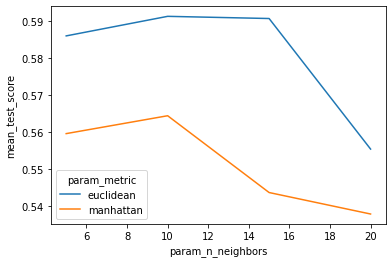

In [94]:

sns.lineplot(x='param_n_neighbors',y='mean_test_score', data=knn_df,hue='param_metric')
plt.show()

### (3) Decision Tree

In [125]:
dt_model = DecisionTreeRegressor()

In [144]:
dt_param = {'max_depth' :range(1,11) ,'min_samples_leaf' : range(50,201,20)}
dt_model_gs = GridSearchCV(dt_model, dt_param, cv=5, verbose=3,scoring = 'neg_mean_absolute_error')

In [146]:
dt_model_gs.fit(x_train,y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END ...............max_depth=1, min_samples_leaf=50; total time=   0.0s
[CV 2/5] END ...............max_depth=1, min_samples_leaf=50; total time=   0.0s
[CV 3/5] END ...............max_depth=1, min_samples_leaf=50; total time=   0.0s
[CV 4/5] END ...............max_depth=1, min_samples_leaf=50; total time=   0.0s
[CV 5/5] END ...............max_depth=1, min_samples_leaf=50; total time=   0.0s
[CV 1/5] END ...............max_depth=1, min_samples_leaf=70; total time=   0.0s
[CV 2/5] END ...............max_depth=1, min_samples_leaf=70; total time=   0.0s
[CV 3/5] END ...............max_depth=1, min_samples_leaf=70; total time=   0.0s
[CV 4/5] END ...............max_depth=1, min_samples_leaf=70; total time=   0.0s
[CV 5/5] END ...............max_depth=1, min_samples_leaf=70; total time=   0.0s
[CV 1/5] END ...............max_depth=1, min_samples_leaf=90; total time=   0.0s
[CV 2/5] END ...............max_depth=1, min_sa

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 11),
                         'min_samples_leaf': range(50, 201, 20)},
             scoring='neg_mean_absolute_error', verbose=3)

In [147]:
dt_model_gs.best_estimator_

DecisionTreeRegressor(max_depth=2, min_samples_leaf=90)

In [148]:
dt_model_gs.best_score_

-1.944865354493773

In [149]:
dt_df = pd.DataFrame(dt_model_gs.cv_results_)
dt_df = dt_df.loc[:,['param_max_depth','param_min_samples_leaf','mean_test_score']]

In [150]:
dt_df.head()

,param_max_depth,param_min_samples_leaf,mean_test_score
0,1,50,-2.033495
1,1,70,-2.001818
2,1,90,-1.944865
3,1,110,-2.006060
4,1,130,-2.255647


In [151]:
dt_pred_gs = dt_model_gs.predict(x_val)

In [159]:
print('rmse:',mean_squared_error(y_val, dt_pred_gs, squared=False))
print('mae:',mean_absolute_error(y_val, dt_pred_gs))
print('정확도:',1 - mean_absolute_percentage_error(y_val, dt_pred_gs))

rmse: 2.543506552859365
mae: 2.017660387398893
정확도: 0.6665069293237558


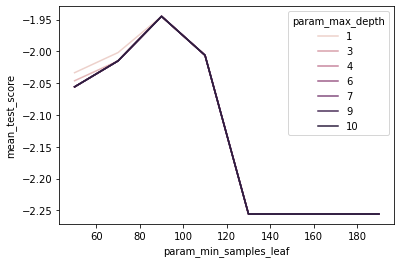

In [154]:
sns.lineplot(x='param_min_samples_leaf',y='mean_test_score', data=dt_df,hue='param_max_depth')
plt.show()

### (4) Random Forest

In [160]:
rndf_model = RandomForestRegressor()

In [168]:
rndf_param = {'n_estimators': range(5,201,50),'max_features': range(1,x_train.shape[1]+1)}
rndf_model_gx = GridSearchCV(rndf_model,rndf_param,cv=5,verbose=3)

In [169]:
rndf_model_gx.fit(x_train,y_train)

Fitting 5 folds for each of 44 candidates, totalling 220 fits
[CV 1/5] END .................max_features=1, n_estimators=5; total time=   0.0s
[CV 2/5] END .................max_features=1, n_estimators=5; total time=   0.0s
[CV 3/5] END .................max_features=1, n_estimators=5; total time=   0.0s
[CV 4/5] END .................max_features=1, n_estimators=5; total time=   0.0s
[CV 5/5] END .................max_features=1, n_estimators=5; total time=   0.0s
[CV 1/5] END ................max_features=1, n_estimators=55; total time=   0.0s
[CV 2/5] END ................max_features=1, n_estimators=55; total time=   0.0s
[CV 3/5] END ................max_features=1, n_estimators=55; total time=   0.0s
[CV 4/5] END ................max_features=1, n_estimators=55; total time=   0.0s
[CV 5/5] END ................max_features=1, n_estimators=55; total time=   0.0s
[CV 1/5] END ...............max_features=1, n_estimators=105; total time=   0.0s
[CV 2/5] END ...............max_features=1, n_e

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': range(1, 12),
                         'n_estimators': range(5, 201, 50)},
             verbose=3)

In [170]:
rndf_model_gx.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=155)

In [171]:
rndf_model_gx.best_score_

0.7357507511910253

In [176]:
rndf_df = pd.DataFrame(rndf_model_gx.cv_results_)
rndf_df = rndf_df.loc[:,['param_n_estimators','param_max_features','mean_test_score']]

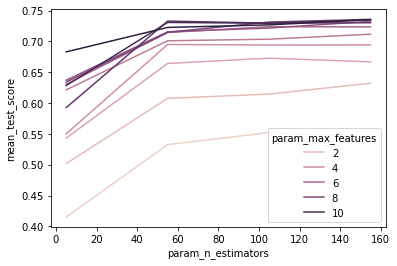

In [180]:
sns.lineplot(x='param_n_estimators',y='mean_test_score', data=rndf_df,hue='param_max_features')
plt.show()

In [194]:
rndf_pred_gx= rndf_model_gx.predict(x_val)

In [195]:
print('rmse:',mean_squared_error(y_val, rndf_pred_gx, squared=False))
print('mae:',mean_absolute_error(y_val, rndf_pred_gx))
print('정확도:',1 - mean_absolute_percentage_error(y_val, rndf_pred_gx))

rmse: 1.3850374868548005
mae: 1.1182123655913978
정확도: 0.8139337877271359


### (5) SVM

In [181]:
svm_model = SVR()

In [188]:
svm_param = {'C': np.linspace(0.01,100,50), 'gamma': [0.001, 0.05, 0.1,0.5,1,1.5]}
svm_param

{'C': array([1.00000000e-02, 2.05061224e+00, 4.09122449e+00, 6.13183673e+00,
        8.17244898e+00, 1.02130612e+01, 1.22536735e+01, 1.42942857e+01,
        1.63348980e+01, 1.83755102e+01, 2.04161224e+01, 2.24567347e+01,
        2.44973469e+01, 2.65379592e+01, 2.85785714e+01, 3.06191837e+01,
        3.26597959e+01, 3.47004082e+01, 3.67410204e+01, 3.87816327e+01,
        4.08222449e+01, 4.28628571e+01, 4.49034694e+01, 4.69440816e+01,
        4.89846939e+01, 5.10253061e+01, 5.30659184e+01, 5.51065306e+01,
        5.71471429e+01, 5.91877551e+01, 6.12283673e+01, 6.32689796e+01,
        6.53095918e+01, 6.73502041e+01, 6.93908163e+01, 7.14314286e+01,
        7.34720408e+01, 7.55126531e+01, 7.75532653e+01, 7.95938776e+01,
        8.16344898e+01, 8.36751020e+01, 8.57157143e+01, 8.77563265e+01,
        8.97969388e+01, 9.18375510e+01, 9.38781633e+01, 9.59187755e+01,
        9.79593878e+01, 1.00000000e+02]),
 'gamma': [0.001, 0.05, 0.1, 0.5, 1, 1.5]}

In [190]:
svm_model_gs = GridSearchCV(svm_model, svm_param,  cv=5, verbose=3)

In [191]:
svm_model_gs.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': array([1.00000000e-02, 2.05061224e+00, 4.09122449e+00, 6.13183673e+00,
       8.17244898e+00, 1.02130612e+01, 1.22536735e+01, 1.42942857e+01,
       1.63348980e+01, 1.83755102e+01, 2.04161224e+01, 2.24567347e+01,
       2.44973469e+01, 2.65379592e+01, 2.85785714e+01, 3.06191837e+01,
       3.26597959e+01, 3.47004082e+01, 3.67410204e+01, 3.878163...
       5.71471429e+01, 5.91877551e+01, 6.12283673e+01, 6.32689796e+01,
       6.53095918e+01, 6.73502041e+01, 6.93908163e+01, 7.14314286e+01,
       7.34720408e+01, 7.55126531e+01, 7.75532653e+01, 7.95938776e+01,
       8.16344898e+01, 8.36751020e+01, 8.57157143e+01, 8.77563265e+01,
       8.97969388e+01, 9.18375510e+01, 9.38781633e+01, 9.59187755e+01,
       9.79593878e+01, 1.00000000e+02]),
                         'gamma': [0.001, 0.05, 0.1, 0.5, 1, 1.5]})

In [196]:
svm_model_gs.best_estimator_

SVR(C=2.050612244897959, gamma=0.001)

In [197]:
svm_model_gs.best_score_

0.11768204314103214

In [203]:
svm_df = pd.DataFrame(svm_model_gs.cv_results_)
svm_df = svm_df.loc[:,['param_C','param_gamma','mean_test_score']]

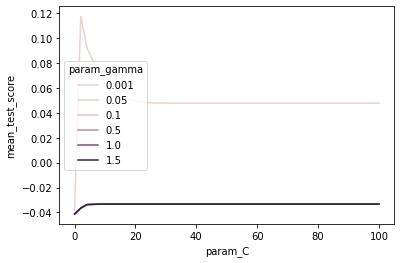

In [204]:
sns.lineplot(x='param_C',y='mean_test_score', data=svm_df, hue='param_gamma')
plt.show()

In [205]:
svm_pred_gs = svm_model_gs.predict(x_val)

In [206]:
print('rmse:',mean_squared_error(y_val, svm_pred_gs, squared=False))
print('mae:',mean_absolute_error(y_val, svm_pred_gs))
print('정확도:',1 - mean_absolute_percentage_error(y_val, svm_pred_gs))

rmse: 2.635176819454091
mae: 2.1288607727859623
정확도: 0.6591415358662795


### (6) XGB

In [78]:
xgb_model = XGBRegressor()

In [85]:
xgb_param = {'max_depth' : range(3,8,2), 'n_estimators' : range(50,151,50), 'learning_rate' : [0.01,0.51,1.51]}
xgb_model_gs = GridSearchCV(xgb_model, xgb_param ,cv=5,verbose=3)

In [86]:
xgb_model_gs.fit(x_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=150; total time=   0.0s
[CV 2/5] END learning_rate=0.0

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
        

In [87]:
xgb_model_gs.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.51, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [88]:
xgb_model_gs.best_score_

0.6753143747974926

In [93]:
xgb_df = pd.DataFrame(xgb_model_gs.cv_results_)
xgb_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.067191,0.028175,0.006000,0.000731,0.01,3,50,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-2.423853,-2.243334,-2.604503,-1.657465,-1.525421,-2.090915,0.425562,27
1,0.081413,0.009687,0.005969,0.000312,0.01,3,100,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-0.606575,-0.416109,-0.721366,-0.251092,-0.165619,-0.432152,0.208877,24
2,0.119006,0.007296,0.006260,0.000520,0.01,3,150,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.114318,0.280617,0.079105,0.294875,0.368160,0.227415,0.111335,12
3,0.049411,0.004065,0.006459,0.000471,0.01,5,50,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-2.398923,-2.192404,-2.538716,-1.683543,-1.481595,-2.059036,0.409350,25
4,0.122116,0.034900,0.006746,0.001133,0.01,5,100,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-0.543468,-0.372656,-0.653215,-0.266837,-0.104862,-0.388208,0.194726,22


In [96]:
xgb_df = xgb_df.loc[:,['param_max_depth','param_n_estimators','param_learning_rate','mean_test_score']]
xgb_df.head()

,param_max_depth,param_n_estimators,param_learning_rate,mean_test_score
0,3,50,0.01,-2.090915
1,3,100,0.01,-0.432152
2,3,150,0.01,0.227415
3,5,50,0.01,-2.059036
4,5,100,0.01,-0.388208


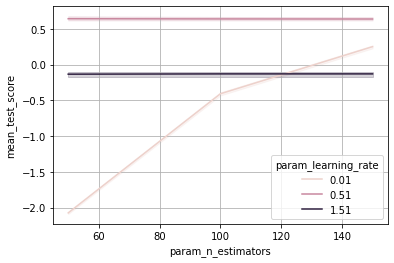

In [98]:

sns.lineplot(x='param_n_estimators',y='mean_test_score', data=xgb_df,hue='param_learning_rate')
plt.grid()
plt.show()

(6) SVM

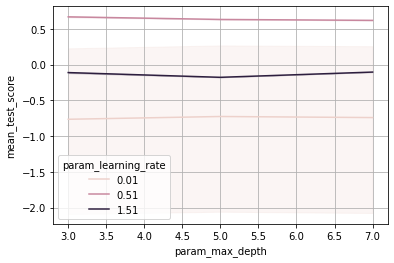

In [99]:
sns.lineplot(x='param_max_depth',y='mean_test_score', data=xgb_df,hue='param_learning_rate')
plt.grid()
plt.show()

In [100]:
xgb_pred_gs = xgb_model_gs.predict(x_val)

In [101]:
print(mean_squared_error(y_val, xgb_pred_gs, squared=False))
print(mean_absolute_error(y_val, xgb_pred_gs))
print(1 - mean_absolute_percentage_error(y_val, xgb_pred_gs))

2.094778348745158
1.700436073621114
0.7424495301078271
